
# 基于 pyqcat-monster 的多比特表征流程

在本教程中，我们将演示如何使用 pyqcat-monster 进行多比特表征流程测试。在这里你可以了解到：

- 基于 monster 的多比特表征流程测试；
- 基于 montser 的相关 API 使用方式；

在此基础上，我们还提供了 [monster]() 的 API 文档，期待您的阅读。当您发现有错误或者需要优化的地方，欢迎您通过 [pyqcat社区](https://document.qpanda.cn/space/9030MdOBwNfe5oqw) 向我们反馈，您的意见是我们不断进步的动力！

## 创建实验环境

- 若您未安装 pyqcat 包（monster），通过本地源码测试，需要执行下面操作，将 monster 项目环境加载到 jupyter 中；
- 若安装了 pyqcat 包（monster），跳过此步骤

In [1]:
# import sys

# package_root = "../../pyqcat-monster"
# sys.path.insert(0, package_root)

### 导入依赖包

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pyQCat.qubit import Qubit
from pyQCat.tools import qarange
from pyQCat.context import ExperimentContext
from pyQCat.invoker import Invoker
from pyQCat.parameters import get_parameters
from pyQCat.types import Quality
from pyQCat.log import pyqlog
from pyQCat.experiments import *
from pyQCat.analysis.fit.fit_models import freq2amp_formula


%matplotlib notebook
pd.set_option('max_colwidth', None)

### 用户信息配置

In [2]:
conf_file = r'F:\MonsterTest_QT8013\conf\config.conf'

username = "wangpeng"
password = "8013"


# Invoker.verify_account(username=username, password=password)
Invoker.load_account()

{'code': 200,
 'data': {'username': 'wangpeng',
  'groups': 'normal',
  'email': 'pwang0110@mail.ustc.edu.cn',
  'phone_num': None,
  'is_super': False,
  'is_admin': False,
  'status': 0,
  'create_time': '2022-11-11 16:58:11',
  'last_login_time': '2022-12-09 11:43:34',
  'id': '636e0ea3eac949e7d31db591'},
 'msg': 'success'}

### 检索系统配置信息

In [3]:
pd.DataFrame(context.config_table())

NameError: name 'context' is not defined

## 校准读取比特

### 环境创建

In [5]:
def single_qubit_cali_context(
    qubit_name: str,
    parking_bits: list,
    parking_zamp: list,
    env_bit: list,
    use_dcm: bool = False,
    ac_switch: bool = True
):
    """ 应用场景：
        - 单比特表征所有流程
    """
    context = ExperimentContext(conf_file)
    context.configure_inst()

    context.configure_qubits(qubit_name)
    
    
    new_env_bit = []
    for bit in env_bit:
        base_bit = context.get_base_qubit(bit)
        if base_bit.name == qubit_name:
            base_bit.ac = base_bit.dc_max
        elif base_bit.name in parking_bits:
            base_bit.ac = base_bit.dc_max + parking_zamp[parking_bits.index(base_bit.name)]
        elif isinstance(base_bit, Qubit):
            base_bit.ac = base_bit.dc_min
        else:
            base_bit.ac = base_bit.dc_max
        new_env_bit.append(base_bit)
        base_bit.save_data()

    if ac_switch:
        context.maximize_compensate()
    else:
        context.minimize_compensate()
    context.configure_environment(new_env_bit)
    context.configure_crosstalk_dict()

    if use_dcm:
        context.configure_dcm(qubit_name)

    return context

In [83]:
q_name = "q70"
ENV_BIT = ["q64", "q65", "q69", "q70", "q71", "q72", "c6470", "c6571", "c6970", "c7071", "c7172"]

parking_bits = ['q71']
parking_zamp = [0]

context = single_qubit_cali_context(q_name, parking_bits, parking_zamp, ENV_BIT, use_dcm=False, ac_switch=True)
qubit = context.qubit

2022-12-12 12:03:35 |   INFO   | 
|=============================================================|
|                       Invoker Envrion                       |
|=============================================================|
|    invoker_addr    |       tcp://192.168.110.211:8088       |
|    point_label     |              freestyle_2q              |
|       sample       |220826-72bit-300pin-V8.2-Base-24#_monster|
|      env_name      |             D1_env(QT8013)             |
|      version       |                0.0.2.2                 |
|=============================================================|

2022-12-12 12:03:35 |  UPDATE  | Save q64 to data service success.
2022-12-12 12:03:35 |  UPDATE  | Save q65 to data service success.
2022-12-12 12:03:35 |  UPDATE  | Save q69 to data service success.
2022-12-12 12:03:35 |  UPDATE  | Save q70 to data service success.
2022-12-12 12:03:35 |  UPDATE  | Save q71 to data service success.
2022-12-12 12:03:35 |  UPDATE  | Save q72 to data ser

In [12]:
# with open("E:/Data/D1/20221107/work_pint.json","r") as f:
#     work_pint = json.load(f)
# print(work_pint)
# for bit in ENV_BIT:
#     if bit[0] is 'q':
#         q = get_parameters('qubit',bit)
#         q.dc_max = work_pint[bit][0]
#         q.dc_min = work_pint[bit][1]
#         q.save_data()
#     elif bit[0] is 'c':
#         q = get_parameters('coupler',bit)
#         q.dc_max = work_pint[bit][0]
#         q.dc_min = work_pint[bit][1]
#         q.save_data()

{'q69': [-0.026, 0.117], 'q70': [-0.063, 0.082], 'q71': [-0.057, 0.095], 'q72': [-0.03, 0.109], 'q64': [-0.056, 0.094], 'q65': [-0.063, 0.083], 'c6470': [-0.133, 0.092], 'c6571': [-0.125, 0.0], 'c6970': [0.089, -0.08], 'c7071': [0.108, -0.045], 'c7172': [0.087, -0.058]}
2022-12-12 10:52:19 |  UPDATE  | Save q64 to data service success.
2022-12-12 10:52:19 |  UPDATE  | Save q65 to data service success.
2022-12-12 10:52:19 |  UPDATE  | Save q69 to data service success.
2022-12-12 10:52:19 |  UPDATE  | Save q70 to data service success.
2022-12-12 10:52:19 |  UPDATE  | Save q71 to data service success.
2022-12-12 10:52:19 |  UPDATE  | Save q72 to data service success.
2022-12-12 10:52:19 |  UPDATE  | Save c6470 to data service success.
2022-12-12 10:52:19 |  UPDATE  | Save c6571 to data service success.
2022-12-12 10:52:19 |  UPDATE  | Save c6970 to data service success.
2022-12-12 10:52:19 |  UPDATE  | Save c7071 to data service success.
2022-12-12 10:52:19 |  UPDATE  | Save c7172 to data

In [7]:
qubit.z_dc_channel = 21
qubit.dc = -0.278
qubit.save_data()

2022-12-12 10:49:03 |  UPDATE  | Save q70 to data service success.


#### 检索实验环境配置参数

In [11]:
pd.DataFrame(context.context_table())

,parameter,object,count
0,config,F:\MonsterTest_QT8013\conf\config.conf,
1,qubits,[Qubit(bit=70)],1
2,couplers,[],0
3,discriminators,None,0
4,compensates,"{Qubit(bit=64): PulseCorrectionQ64, Qubit(bit=65): PulseCorrectionQ65, Qubit(bit=69): PulseCorrectionQ69, Qubit(bit=70): PulseCorrectionQ70, Qubit(bit=71): PulseCorrectionQ71, Qubit(bit=72): PulseCorrectionQ72, Coupler(bit=6470, driveQ64, probeQ70): PulseCorrectionC6470, Coupler(bit=6571, driveQ65, probeQ71): PulseCorrectionC6571, Coupler(bit=6970, driveQ69, probeQ70): PulseCorrectionC6970, Coupler(bit=7071, driveQ71, probeQ70): PulseCorrectionC7071, Coupler(bit=7172, driveQ71, probeQ72): PulseCorrectionC7172}",11
5,working_dc,True,
6,crosstalk_dict,False,


#### 检索初始比特参数信息

In [16]:
pd.DataFrame(context.base_qubit_table(context.qubit))

,parameter,value,unit,update_time
0,tunable,True,-,None
1,goodness,False,-,None
2,drive_freq,4796.436,MHz,None
3,drive_power,-10,db,None
4,probe_freq,7126.372,MHz,None
5,probe_power,-32,db,None
6,tls_freq,None,MHz,None
7,anharmonicity,-240,db,None
8,dc,-0.278,v,None
9,dc_max,-0.063,v,None


#### 检索 DC 配置信息

In [11]:
pd.DataFrame(context.work_dc_table())

,qubit,z_dc_channel,value
0,Coupler(bit=7172),9,0.0v
1,Qubit(bit=71),21,-0.278v


In [89]:
pd.DataFrame(context.work_ac_table())

,qubit,z_flux_channel,value,m_pulse_model,m_pulse_params,compensate
0,Qubit(bit=64),14,0.094v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ64
1,Qubit(bit=65),9,0.083v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ65
2,Qubit(bit=69),22,0.117v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ69
3,Qubit(bit=70),21,-0.063v,FlatTopGaussian,"Options(amp=0.01, sigma=1.25, buffer=5)",PulseCorrectionQ70
4,Qubit(bit=71),18,-0.057v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ71
5,Qubit(bit=72),13,0.109v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ72
6,"Coupler(bit=6470, driveQ64, probeQ70)",23,-0.133v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC6470
7,"Coupler(bit=6571, driveQ65, probeQ71)",16,-0.125v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC6571
8,"Coupler(bit=6970, driveQ69, probeQ70)",24,0.089v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC6970
9,"Coupler(bit=7071, driveQ71, probeQ70)",19,0.108v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC7071


#### 检索线路补偿器信息

In [15]:
pd.DataFrame(context.compensates_table())

,name,x_delay,z_delay,z_compensate,distortion_width,distortion_data_len,distortion_ab,distortion_type
0,q64,0.0,0.000,0.0,0.0,0,[],width
1,q65,0.0,0.000,0.0,0.0,0,[],width
2,q69,0.0,0.000,0.0,0.0,0,[],width
3,q70,0.0,30.000,0.0,4405.0,157,[],width
4,q71,0.0,28.750,0.0,7605.0,12169,[],width
5,q72,0.0,0.000,0.0,0.0,0,[],width
6,c6470,0.0,0.000,0.0,0.0,0,[],width
7,c6571,0.0,0.000,0.0,0.0,0,[],width
8,c6970,0.0,0.000,0.0,0.0,0,[],width
9,c7071,0.0,35.625,0.0,9905.0,15849,[],width


### CavitySpecturm

2022-12-12 11:56:31 |   EXP    | CavityFreqSpectrum register success, id 6396a66fbdc7464e55fa4f7e
2022-12-12 11:56:31 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\CavityFreqSpectrum\q70\2022-12-12\11.56.31\


<IPython.core.display.Javascript object>


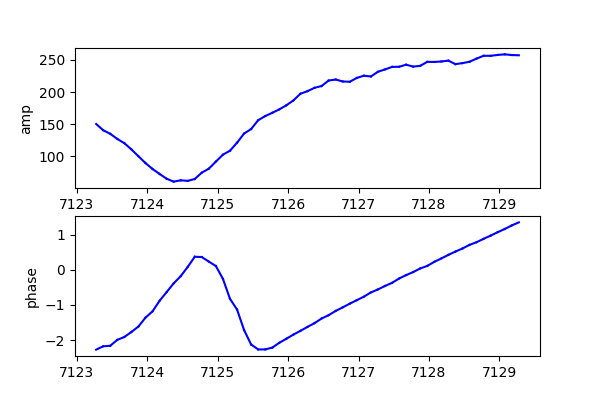

  0%|          | 0/61 [00:00<?, ?it/s]

2022-12-12 11:58:04 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |      quality       | 
----------------------------------------------------------
|  fr  |    fc    | 7124.484 | MHz  | R²=0.9986(perfect) | 


In [70]:
cs_exp = CavityFreqSpectrum.from_experiment_context(context)

cs_exp.set_experiment_options(
    ac_prepare_time=1000,
    add_pi_pulse=False,
#     simulator_data_path='../scripts/simulator/data/CavityFreqSpectrum/',
    readout_power=-40,
)

cs_exp.set_analysis_options(
    is_plot=True,
    quality_bounds=[0.98, 0.95, 0.85]
)

cs_exp.run()

#### 查看实验结果

In [28]:
pd.DataFrame(cs_exp.analysis.show_results())

,name,value,unit,extra,quality
0,fc,7126.654,MHz,{},R²=0.9988(perfect)


#### 查看实验结果图

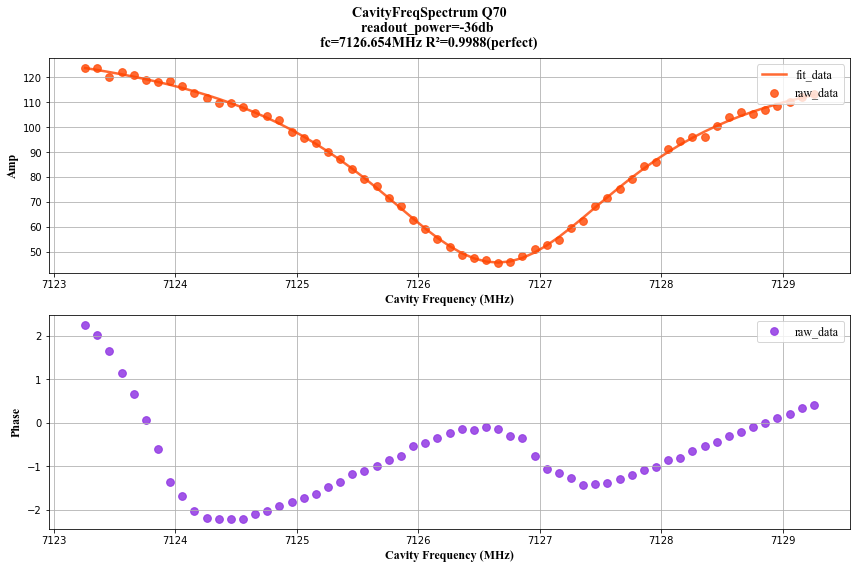

In [29]:
cs_exp.analysis.drawer.figure

#### 判断结果质量并更新数据库

In [16]:
if cs_exp.analysis.quality.descriptor in [Quality.perfect, Quality.normal]:
    qubit.probe_freq = cs_exp.analysis.results.fr.value
    qubit.probe_power = cs_exp.experiment_options.readout_power
    pyqlog.info(f'Update {qubit} probe_freq {qubit.probe_freq}MHz, probe_power {qubit.probe_power}db')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-12 10:53:47 |   INFO   | Update Qubit(bit=70) probe_freq 7126.649MHz, probe_power -40db
2022-12-12 10:53:47 |  UPDATE  | Save q70 to data service success.


In [35]:
qubit.xy_channel = 25

In [36]:
context.qubit.xy_channel

25

### QubitSpecturm

2022-12-12 10:53:50 |   EXP    | QubitSpectrum register success, id 639697bebdc7464e55fa4b75
2022-12-12 10:53:50 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\QubitSpectrum\q70\2022-12-12\10.53.50\


<IPython.core.display.Javascript object>


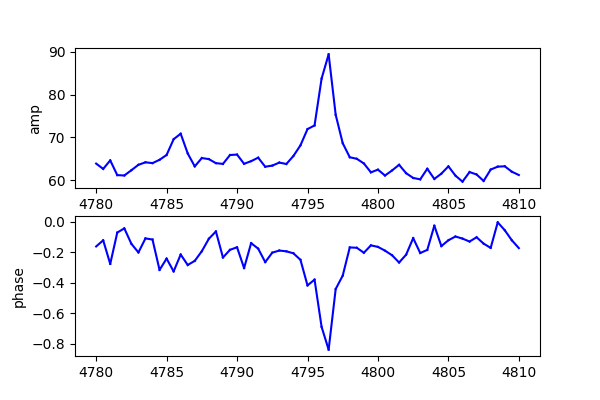

  0%|          | 0/61 [00:00<?, ?it/s]

2022-12-12 10:54:53 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |      quality       | 
----------------------------------------------------------
| freq |   f01    | 4796.323 | MHz  | R²=0.8285(perfect) | 


In [17]:
qs_exp2 = QubitSpectrum.from_experiment_context(context)

qs_exp2.set_experiment_options(
    ac_prepare_time=1000,
    freq_list=qarange(4780, 4810, 0.5),
    drive_power=-40,
    z_amp=None,
    use_square=True,
    band_width=10,
    fine_flag=True,
#     simulator_data_path='../scripts/simulator/data/QubitSpectrum/5000Mhz/fine/'
)

qs_exp2.set_analysis_options(
    snr_bounds=1.5,
    quality_bounds=[0.8, 0.6, 0.5],
    is_plot=True,
)

qs_exp2.run()

#### 查看实验结果

In [38]:
pd.DataFrame(qs_exp2.analysis.show_results())

,name,value,unit,extra,quality
0,f01,4796.256,MHz,{},R²=0.8255(perfect)


#### 查看实验结果图

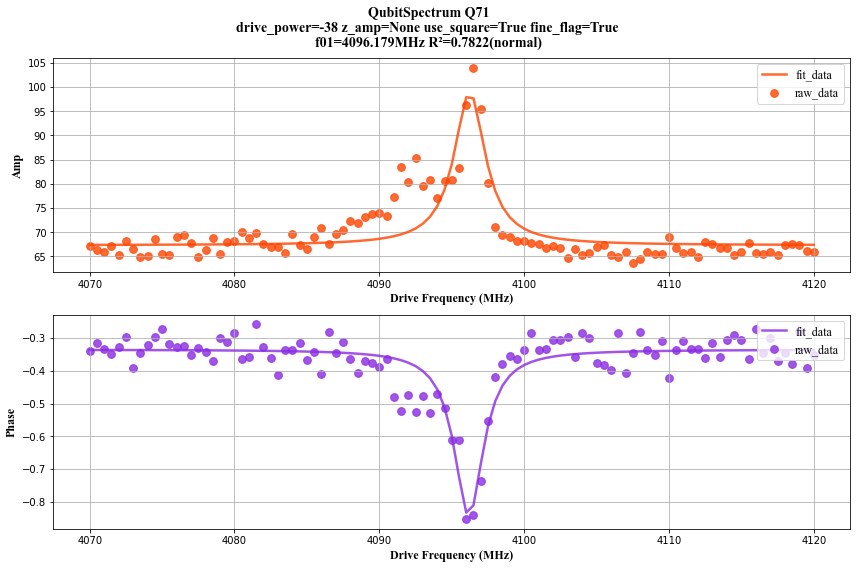

In [72]:
qs_exp2.analysis.drawer.figure

In [18]:
qs_exp2.analysis.results.freq.value

4796.323

### RabiScanWidth

扫描 `Drag` 的脉冲宽度，通过其振荡规律判断比特频率是否正确

2022-12-12 10:55:11 |   EXP    | RabiScanWidth register success, id 6396980fbdc7464e55fa4ba4
2022-12-12 10:55:11 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\RabiScanWidth\q70\2022-12-12\10.55.06\


<IPython.core.display.Javascript object>


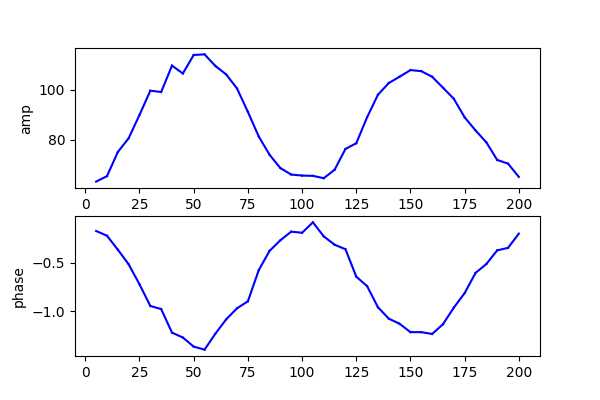

  0%|          | 0/40 [00:00<?, ?it/s]

'scipy.optimize.curve_fit failed with error: `x0` is infeasible.'
'scipy.optimize.curve_fit failed with error: `x0` is infeasible.'
'scipy.optimize.curve_fit failed with error: `x0` is infeasible.'
'scipy.optimize.curve_fit failed with error: `x0` is infeasible.'
2022-12-12 10:56:07 |  RESULT  | Experiment results as follow:
|    name     |  describe   | value | unit |      quality      | 
----------------------------------------------------------------
| oscillating | oscillating | True  | None | R²=0.981(perfect) | 


In [19]:
rsw = RabiScanWidth.from_experiment_context(context)

rsw.set_experiment_options(
    ac_prepare_time=1000,
    drive_freq=4796.323,
    drive_power=-10,
#     simulator_data_path='../scripts/simulator/data/RabiScanWidth'
)

rsw.run()

#### 查看实验结果图

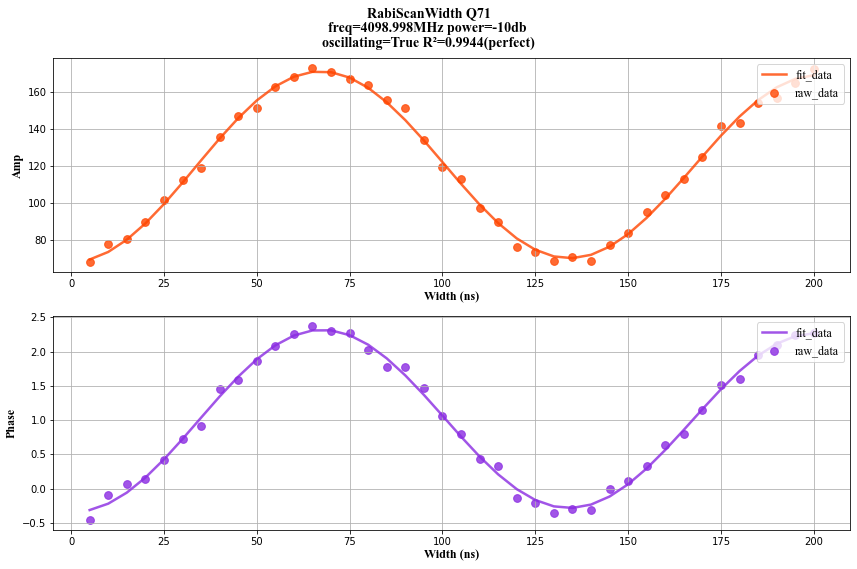

In [68]:
rsw.analysis.drawer.figure

#### 根据能谱和 RabiWidth 判断是否更新比特频率

In [20]:
qs_quality = qs_exp2.analysis.quality.descriptor
oscillating = rsw.analysis.results.oscillating.value

if qs_quality in [Quality.perfect, Quality.normal] and oscillating:
    qubit.drive_freq = qs_exp2.analysis.results.freq.value
    qubit.drive_power = qs_exp2.experiment_options.drive_power
    pyqlog.info(f'Update {qubit} drive_freq {qubit.drive_freq}MHz, drive_power {qubit.drive_power}db')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-12 10:56:07 |   INFO   | Update Qubit(bit=70) drive_freq 4796.323MHz, drive_power -40db
2022-12-12 10:56:07 |  UPDATE  | Save q70 to data service success.


In [21]:
qubit.XYwave.time = 50
# qubit.drive_freq = 4794.108
qubit.save_data()

2022-12-12 10:56:07 |  UPDATE  | Save q70 to data service success.


In [22]:
qubit.XYwave.time

50

### XpiDetection

XpiDetune 实验是对 RabiScanAmp 实验的封装， 扫描 `Drag` 幅值，粗测 `X` 门幅值

2022-12-12 10:56:28 |   EXP    | The expect_value is 0.7.
2022-12-12 10:56:28 |   EXP    | The max test time is 5.
2022-12-12 10:56:28 |   EXP    | RabiScanAmp count 0, drive_power -10
2022-12-12 10:56:35 |   EXP    | RabiScanAmp register success, id 63969863bdc7464e55fa4bd9
2022-12-12 10:56:35 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\XpiDetection\q70\2022-12-12\10.56.28\RabiScanAmp\10-56-28-count=0-drive_power=-10\


<IPython.core.display.Javascript object>


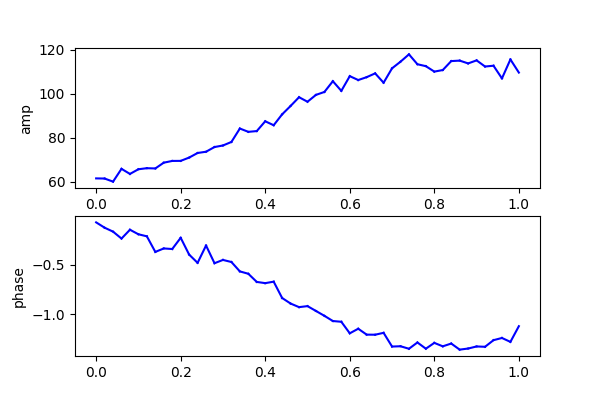

  0%|          | 0/51 [00:00<?, ?it/s]

2022-12-12 10:57:28 |  RESULT  | Experiment results as follow:
|    name     | describe | value | unit |      quality       | 
--------------------------------------------------------------
| drive_power |    dp    |  -10  |  db  | R²=0.9875(perfect) | 
|     Xpi     |  X-amp   | 0.84  |  V   | R²=0.9875(perfect) | 
2022-12-12 10:57:28 |  ERROR   | Failed, update drive_power -8.4, value not in range [-40, -10]


In [23]:
xd = XpiDetection.from_experiment_context(context)

xd.set_experiment_options(
    amps=qarange(0, 1, 0.02),
    drive_power=-10,
    name="Xpi",
#     simulator_data_path='../scripts/simulator/data/XpiDetection/'
)

xd.child_experiment.set_experiment_options(
    ac_prepare_time=1000,
)

xd.run()

#### 查看实验结果

In [46]:
pd.DataFrame(xd.analysis.show_results())

,name,value,unit,extra,quality
0,dp,-10.00,db,{},R²=0.9875(perfect)
1,X-amp,0.82,V,{},R²=0.9875(perfect)


#### 查看实验结果图

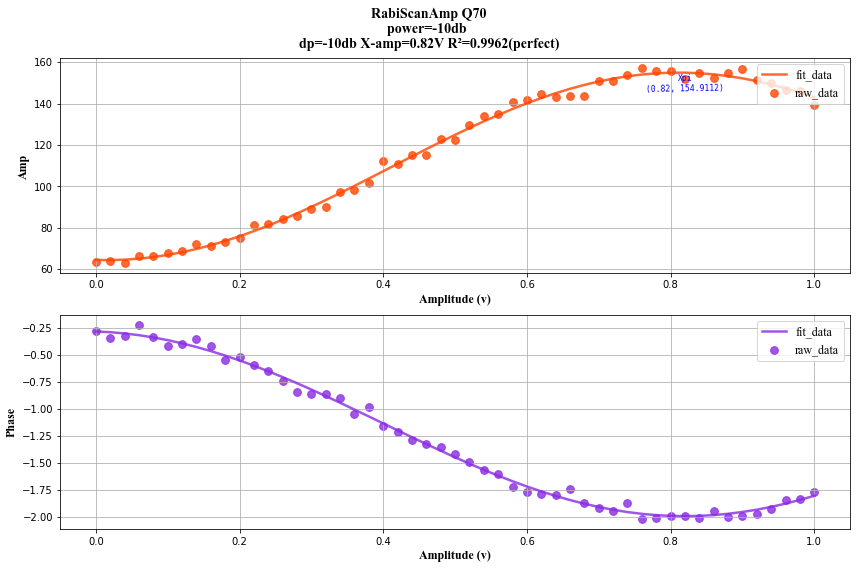

In [13]:
xd.analysis.drawer.figure

#### 检查实验质量并更新比特参数

In [24]:
xd_quality = xd.analysis.quality.descriptor
Xpi = xd.analysis.results.Xpi.value
drive_power = xd.analysis.results.drive_power.value

if xd_quality in [Quality.perfect, Quality.normal]:
    qubit.XYwave.Xpi = Xpi
    qubit.XYwave.Xpi2 = round(Xpi / 2, 3)
    qubit.drive_power = drive_power
    pyqlog.info(f'Update {qubit} Xpi {qubit.XYwave.Xpi}v, Xpi2 {qubit.XYwave.Xpi2}v, drive_power {qubit.drive_power}db')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-12 10:57:35 |   INFO   | Update Qubit(bit=70) Xpi 0.84v, Xpi2 0.42v, drive_power -10db
2022-12-12 10:57:35 |  UPDATE  | Save q70 to data service success.


### ReadoutFreqCalibrate

读取频率优化，此实验执行两次腔能谱实验，第一次不加驱动脉冲测量，第二次加驱动脉冲测量，通过分析两个子实验选择合适的读取频率。

#### 更换读取工作点

In [81]:
qubit.readout_point.amp = 0.01
qubit.save_data()

2022-12-12 12:03:28 |  UPDATE  | Save q70 to data service success.


In [82]:
context.qubit.readout_point

Options(amp=0.01, sigma=1.25, buffer=5)

In [9]:
qubit.probe_power = -36
qubit.save_data()

2022-12-07 16:10:17 |  UPDATE  | Save q70 to data service success.


2022-12-12 12:06:18 |   EXP    | CavityFreqSpectrum register success, id 6396a8babdc7464e55fa4f9a
2022-12-12 12:06:18 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutFreqCalibrate\q70\2022-12-12\12.06.17\CavityFreqSpectrum\12-06-18-xy_pulse amp=0\


<IPython.core.display.Javascript object>


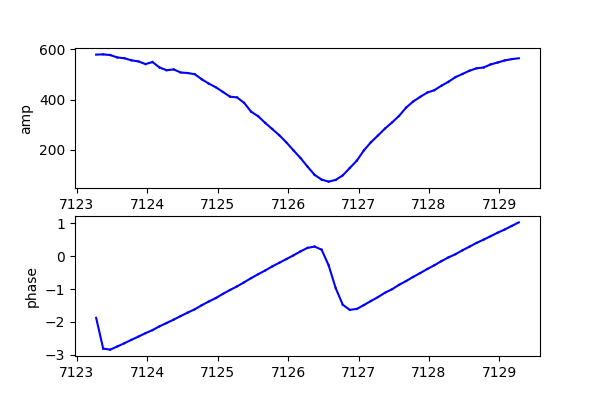

  0%|          | 0/61 [00:00<?, ?it/s]

2022-12-12 12:07:19 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |      quality       | 
----------------------------------------------------------
|  fr  |    fc    | 7126.588 | MHz  | R²=0.9978(perfect) | 
2022-12-12 12:07:19 |   EXP    | CavityFreqSpectrum register success, id 6396a8f7bdc7464e55fa4f9c
2022-12-12 12:07:19 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutFreqCalibrate\q70\2022-12-12\12.06.17\CavityFreqSpectrum\12-07-19-xy_pulse amp=0.8148\


<IPython.core.display.Javascript object>


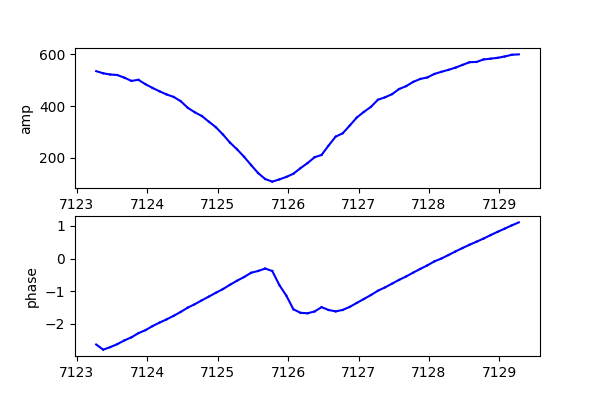

  0%|          | 0/61 [00:00<?, ?it/s]

2022-12-12 12:08:46 |  RESULT  | Experiment results as follow:
| name | describe |  value   | unit |      quality       | 
----------------------------------------------------------
|  fr  |    fc    | 7125.874 | MHz  | R²=0.9987(perfect) | 
2022-12-12 12:08:46 |  RESULT  | Experiment results as follow:
|      name       |   describe   |       value       | unit | quality | 
-----------------------------------------------------------------------
|       fr        |  CavityFreq  |     7126.231      | MHz  |  None   | 
|     mean_fr     |     Mean     |     7126.231      | MHz  |  None   | 
|   distance_fr   |   Distance   |     7123.276      | MHz  |  None   | 
| intersection_fr | Intersection |     7126.176      | MHz  |  None   | 
|    distance     | max amp gap  | 413.5467640763102 |  v   |  None   | 
|      shift      |    shift     |       True        | None |  None   | 


In [85]:
rfc = ReadoutFreqCalibrate.from_experiment_context(context)

rfc.set_experiment_options(
#     simulator_data_path='../scripts/simulator/data/ReadoutFreqCalibrate/'
)

rfc.set_analysis_options(
    distance_flag=False, diff_threshold=0.1
)

rfc.child_experiment.set_experiment_options(
    ac_prepare_time=1000,
)

rfc.child_experiment.set_analysis_options(
    quality_bounds=[0.98, 0.95, 0.85], is_plot=True
)

rfc.run()

#### 查看实验结果

In [56]:
pd.DataFrame(rfc.analysis.show_results())

,name,value,unit,extra,quality
0,CavityFreq,7002.611,MHz,{},None
1,Mean,7002.611,MHz,{},None
2,Distance,7003.404,MHz,{},None
3,Intersection,7002.504,MHz,{},None
4,max amp gap,415.318217,v,"{'out_flag': False, 'value': array([ 12.33230686, 12.40477697, 13.22909507, 12.78455281, 5.07255484, 8.37584472, 6.85783362, 16.15305825, 17.64162235, 27.22179978, 22.00894331, 37.78805251, 23.91856889, 37.02407828, 41.80400122, 85.60944525, 148.33053832, 178.58544242, 237.30635377, 134.06524295, 126.03826365, 242.18648915, 249.47308757, 293.0680542 , 265.58634632, 262.93505675, 256.36230063, 240.80008209, 253.8240393 , 232.55402655, 205.35167134, 188.4357956 , 124.34901689, 330.04093857, 371.9816144 , 415.3182169 , 374.37347773, 151.92486589, 68.33192245, 91.16831815, 88.78256284, 84.27530362, 67.81169886, 59.90868485, 50.10409162, 38.81765983, 36.15117409, 30.76534381, 30.98922459, 23.59821487, 24.01839276, 19.97104616, 14.3811718 , 18.13677179, 14.13837119, 12.36072242, 12.72308916, 11.75674844, 13.291919 , 7.62669637, 9.45675697])}",None
5,shift,True,None,{},None


#### 查看实验结果图

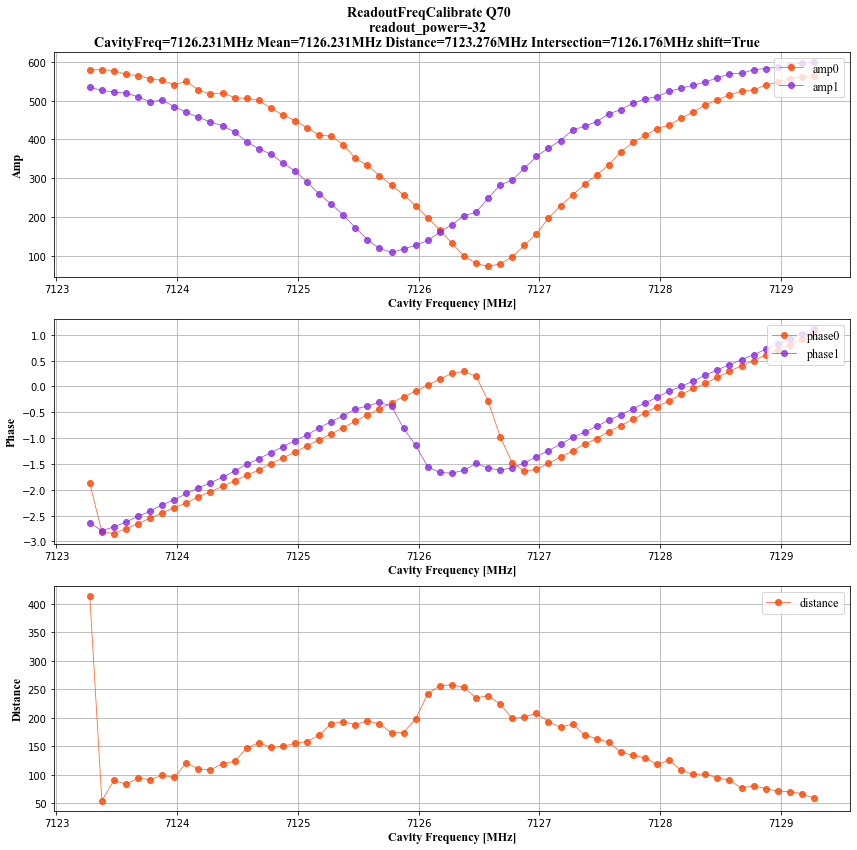

In [86]:
rfc.analysis.drawer.figure

#### 更新比特参数

In [87]:
qubit.probe_freq = rfc.analysis.results.fr.value
qubit.save_data()

2022-12-12 12:09:04 |  UPDATE  | Save q70 to data service success.


### ReadoutPowerCalibrate

读取功率优化，此实验固定其他参数，扫描读取频率执行 `SingleShot` 实验，找到 `IQ` 数据分的最开下的读取功率

In [90]:
rpc = ReadoutPowerCalibrate.from_experiment_context(context)

simulator_data_path = []
power_list = qarange(-40, -26, 2)

rpc.set_experiment_options(
    sweep_list=power_list,
#     simulator_data_path='../scripts/simulator/data/ReadoutPowerCalibrate/'
)

rpc.set_analysis_options(
    fidelity_threshold=[0.8, 0.5],
    outlier=0.011,
)

rpc.child_experiment.set_experiment_options(
    repeat=5000,
    ac_prepare_time=1000,
)

rpc.child_experiment.set_analysis_options(
    quality_bounds=[2, 0.85, 0.7, 0.011], is_plot=True, method="GMM"
)

rpc.run()

2022-12-12 12:09:49 |   EXP    | Run SingleShot probe_power: -40
2022-12-12 12:09:50 |   EXP    | SingleShot register success, id 6396a98ebdc7464e55fa4fd0
2022-12-12 12:09:50 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-12\12.09.49\SingleShot\12-09-49-probe_power=-40\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-12 12:10:31 |  RESULT  | Experiment results as follow:
| name | describe |                       value                       | unit |     quality     | 
------------------------------------------------------------------------------------------------
| q70  |   q70    | K=2 F(0, 1)=[0.8836, 0.7496] AVE=0.8166 OL=0.0076 | None | {'q70': normal} | 
2022-12-12 12:10:31 |   EXP    | Run SingleShot probe_power: -38
2022-12-12 12:10:31 |   EXP    | SingleShot register success, id 6396a9b7bdc7464e55fa4fea
2022-12-12 12:10:31 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-12\12.09.49\SingleShot\12-10-31-probe_power=-38\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-12 12:11:23 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |     quality     | 
-----------------------------------------------------------------------------------------------
| q70  |   q70    | K=2 F(0, 1)=[0.912, 0.8078] AVE=0.8599 OL=0.0086 | None | {'q70': normal} | 
2022-12-12 12:11:23 |   EXP    | Run SingleShot probe_power: -36
2022-12-12 12:11:23 |   EXP    | SingleShot register success, id 6396a9ebbdc7464e55fa5004
2022-12-12 12:11:23 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-12\12.09.49\SingleShot\12-11-23-probe_power=-36\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-12 12:12:15 |  RESULT  | Experiment results as follow:
| name | describe |                       value                       | unit |     quality     | 
------------------------------------------------------------------------------------------------
| q70  |   q70    | K=2 F(0, 1)=[0.9472, 0.8226] AVE=0.8849 OL=0.0066 | None | {'q70': normal} | 
2022-12-12 12:12:15 |   EXP    | Run SingleShot probe_power: -34
2022-12-12 12:12:15 |   EXP    | SingleShot register success, id 6396aa1fbdc7464e55fa501e
2022-12-12 12:12:15 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-12\12.09.49\SingleShot\12-12-15-probe_power=-34\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-12 12:13:07 |  RESULT  | Experiment results as follow:
| name | describe |                       value                       | unit |     quality     | 
------------------------------------------------------------------------------------------------
| q70  |   q70    | K=2 F(0, 1)=[0.9694, 0.8136] AVE=0.8915 OL=0.0082 | None | {'q70': normal} | 
2022-12-12 12:13:07 |   EXP    | Run SingleShot probe_power: -32
2022-12-12 12:13:07 |   EXP    | SingleShot register success, id 6396aa53bdc7464e55fa5038
2022-12-12 12:13:07 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-12\12.09.49\SingleShot\12-13-07-probe_power=-32\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-12 12:13:59 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |     quality     | 
-----------------------------------------------------------------------------------------------
| q70  |   q70    | K=2 F(0, 1)=[0.9742, 0.7778] AVE=0.876 OL=0.0084 | None | {'q70': normal} | 
2022-12-12 12:13:59 |   EXP    | Run SingleShot probe_power: -30
2022-12-12 12:13:59 |   EXP    | SingleShot register success, id 6396aa87bdc7464e55fa5052
2022-12-12 12:13:59 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-12\12.09.49\SingleShot\12-13-59-probe_power=-30\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-12 12:14:51 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |   quality    | 
--------------------------------------------------------------------------------------------
| q70  |   q70    | K=3 F(0, 1)=[0.9706, 0.798] AVE=0.8843 OL=0.0163 | None | {'q70': bad} | 
2022-12-12 12:14:51 |   EXP    | Run SingleShot probe_power: -28
2022-12-12 12:14:51 |   EXP    | SingleShot register success, id 6396aabbbdc7464e55fa506c
2022-12-12 12:14:51 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-12\12.09.49\SingleShot\12-14-51-probe_power=-28\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-12 12:15:43 |  RESULT  | Experiment results as follow:
| name | describe |                      value                      | unit |   quality    | 
-------------------------------------------------------------------------------------------
| q70  |   q70    | K=3 F(0, 1)=[0.901, 0.8472] AVE=0.8741 OL=0.029 | None | {'q70': bad} | 
2022-12-12 12:15:43 |   EXP    | Run SingleShot probe_power: -26
2022-12-12 12:15:43 |   EXP    | SingleShot register success, id 6396aaefbdc7464e55fa5086
2022-12-12 12:15:43 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\ReadoutPowerCalibrate\q70\2022-12-12\12.09.49\SingleShot\12-15-43-probe_power=-26\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-12 12:15:51 |  RESULT  | Experiment results as follow:
| name | describe |                       value                       | unit |   quality    | 
---------------------------------------------------------------------------------------------
| q70  |   q70    | K=3 F(0, 1)=[0.8186, 0.8428] AVE=0.8307 OL=0.0387 | None | {'q70': bad} | 
2022-12-12 12:15:51 |  RESULT  | Experiment results as follow:
|      name      |    describe    | value | unit | quality | 
------------------------------------------------------------
| optimize_field | optimize_field |  -34  | None |  None   | 
| fidelity_flag  | fidelity_flag  | True  | None |  None   | 
|  outlier_flag  |  outlier_flag  | True  | None |  None   | 
|     status     |     status     |   0   | None |  None   | 
2022-12-12 12:15:51 |   FLOW   | Readout Power Calibrate q70 Pass! Readout Power: -34


#### 查询实验结果

In [51]:
pd.DataFrame(rpc.analysis.show_results())

,name,value,unit,extra,quality
0,optimize_field,-34,None,{},None
1,fidelity_flag,True,None,{},None
2,outlier_flag,True,None,{},None
3,status,0,None,{},None


#### 查询实验结果图

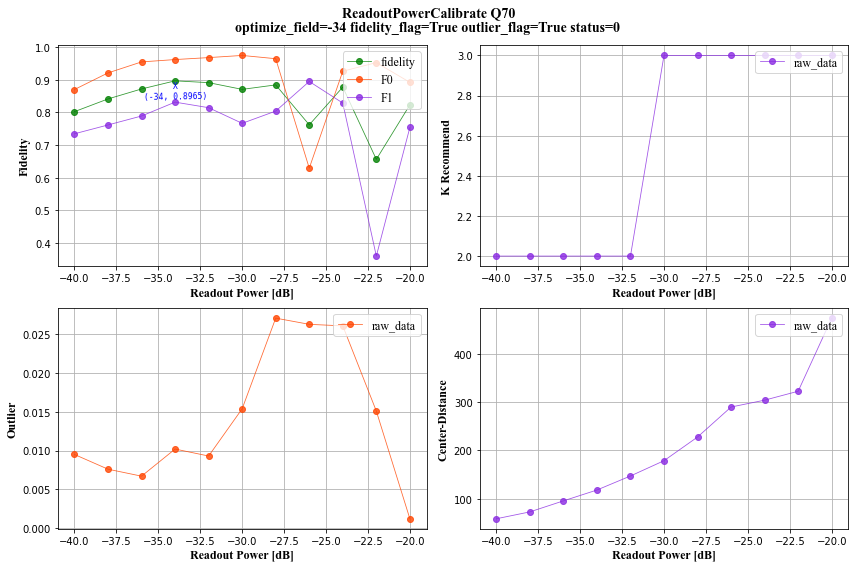

In [30]:
rpc.analysis.drawer.figure

#### 更新比特参数

In [54]:
qubit.probe_power = -32
qubit.save_data()

2022-12-12 11:28:25 |  UPDATE  | Save q70 to data service success.


### SingleShot

获取 `IQ` 分类器

In [55]:
context.discriminators = None

In [84]:
ss = SingleShot.from_experiment_context(context)

ss.set_experiment_options(
    ac_prepare_time=1000,
    repeat=5000,
    is_check=False,
    save_bin=True,
#     simulator_data_path='../scripts/simulator/data/SingleShot/'
)

ss.set_analysis_options(
    method="GMM", quality_bounds=[2, 0.80, 0.65, 0.011], is_plot=True
)

ss.run()

2022-12-12 12:04:26 |   EXP    | SingleShot register success, id 6396a84abdc7464e55fa4f98
2022-12-12 12:04:26 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\SingleShot\q70\2022-12-12\12.04.25\


  0%|          | 0/2 [00:00<?, ?it/s]

2022-12-12 12:05:00 |  RESULT  | Experiment results as follow:
| name | describe |                      value                       | unit |     quality     | 
-----------------------------------------------------------------------------------------------
| q70  |   q70    | K=2 F(0, 1)=[0.976, 0.7744] AVE=0.8752 OL=0.0081 | None | {'q70': normal} | 
2022-12-12 12:05:00 |  UPDATE  | Save q70.bin to data service success.


#### 查询实验结果图

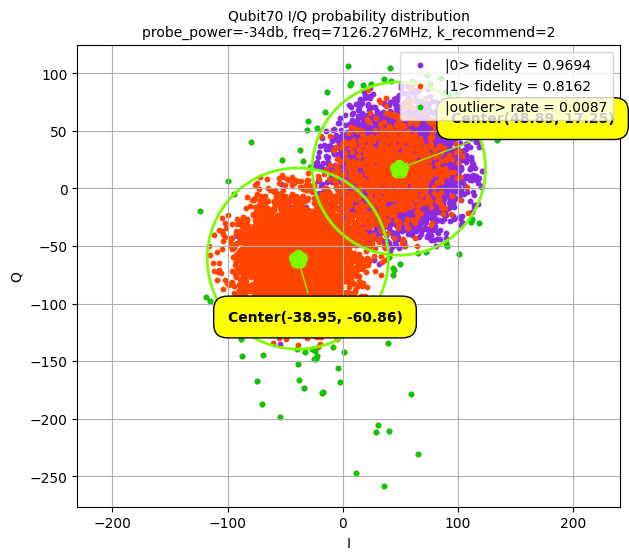

In [46]:
ss.analysis.drawer.figure

#### 为当前实验环境绑定比特判据

In [58]:
context.configure_dcm(q_name)

IQdiscriminator<center=[[ 61.48698285  18.87791135]
 [-52.02004895 -75.5842375 ]]>

### DriveFreqCalibrate


驱动频率校准实验，该实验通过执行两次 `Ramsey` 实验，精细校准比特的驱动频率

In [ ]:
set_subanalysis_options(is_plot=True)

2022-12-12 11:09:51 |   EXP    | Ramsey register success, id 63969b7fbdc7464e55fa4d56
2022-12-12 11:09:51 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\QubitFreqCalibration\q70\2022-12-12\11.09.42\Ramsey\11-09-42-fringe=80MHz\


<IPython.core.display.Javascript object>


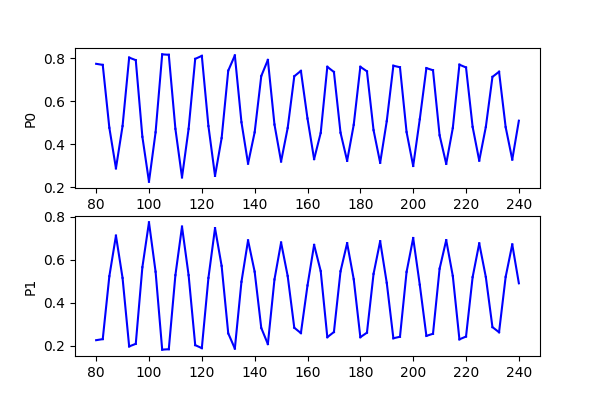

  0%|          | 0/65 [00:00<?, ?it/s]

2022-12-12 11:11:07 |   EXP    | Ramsey register success, id 63969bcabdc7464e55fa4d97
2022-12-12 11:11:07 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\QubitFreqCalibration\q70\2022-12-12\11.09.42\Ramsey\11-10-57-fringe=-80MHz\


<IPython.core.display.Javascript object>


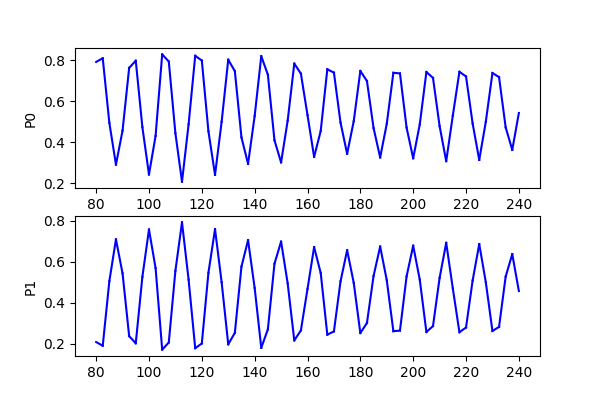

  0%|          | 0/65 [00:00<?, ?it/s]

2022-12-12 11:12:28 |  RESULT  | Experiment results as follow:
|      name       |    describe     |                      value                       | unit |   quality   | 
-------------------------------------------------------------------------------------------------------------
|   f01_records   |   f01_records   | [4636.23976, 4796.20038, 4796.40624, 4956.44562] | MHz  | Quality.bad | 
|       f01       |       f01       |                     4796.303                     | MHz  | Quality.bad | 
| minimum_f01_gap | minimum_f01_gap |                      0.206                       | MHz  | Quality.bad | 


In [36]:
qfc = QubitFreqCalibration.from_experiment_context(context)

qfc.set_experiment_options(
    fringes=[80, -80],
    delays=qarange(80, 240, 2.5),
#     simulator_data_path='../scripts/simulator/data/QubitFreqCalibration/',
    show_result=True,
    
    
)

qfc.set_analysis_options(freq_gap_threshold=0.3,
                         is_plot=True)

qfc.child_experiment.set_analysis_options(
    quality_bounds=[0.98, 0.9, 0.8],
    is_plot=False
)
qfc.child_experiment.set_experiment_options(is_dynamic=1, ac_prepare_time=1000,)
qfc.run()

#### 查询实验结果图

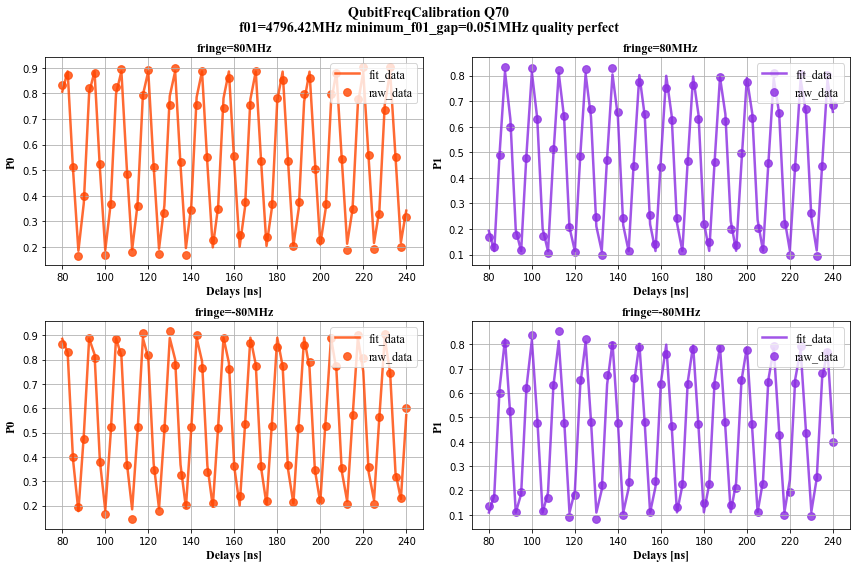

In [27]:
qfc.analysis.drawer.figure

#### 更新比特参数

In [37]:
qfc_quality = qfc.analysis.quality.value
f01 = qfc.analysis.results.f01.value
if qfc_quality == Quality.perfect:
    qubit.drive_freq = f01
    pyqlog.info(f'Update {qubit} drive_freq {qubit.drive_freq}MHz!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-12 11:13:02 |   INFO   | Update Qubit(bit=70) drive_freq 4796.303MHz!
2022-12-12 11:13:02 |  UPDATE  | Save q70 to data service success.


### DetuneCalibration

DetuneCalibration 实验，精细校准失谐量 `detune`

2022-12-12 11:14:41 |   EXP    | theta_type: Xpi, N: 6
2022-12-12 11:14:48 |   EXP    | APE register success, id 63969ca8bdc7464e55fa4dee
2022-12-12 11:14:49 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q70\2022-12-12\11.14.41\APEComposite\11-14-41-RoughScan\APE\11-14-41-N=6\


<IPython.core.display.Javascript object>


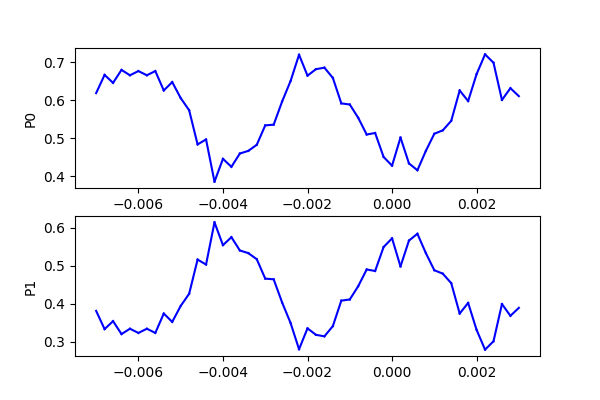

  0%|          | 0/51 [00:00<?, ?it/s]

2022-12-12 11:15:34 |  RESULT  | Experiment results as follow:
|     name     |   describe   |              value              | unit |      quality      | 
--------------------------------------------------------------------------------------------
|   points_0   |   points_0   | detune peaks: [-0.0022, 0.0022] | None | R²=0.9416(normal) | 
| fit_points_0 | fit_points_0 | detune peaks: [-0.006, -0.0018] | None | R²=0.9416(normal) | 
2022-12-12 11:15:34 |   EXP    | theta_type: Xpi, N: 7
2022-12-12 11:15:41 |   EXP    | APE register success, id 63969cddbdc7464e55fa4e2b
2022-12-12 11:15:41 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q70\2022-12-12\11.14.41\APEComposite\11-14-41-RoughScan\APE\11-15-34-N=7\


<IPython.core.display.Javascript object>


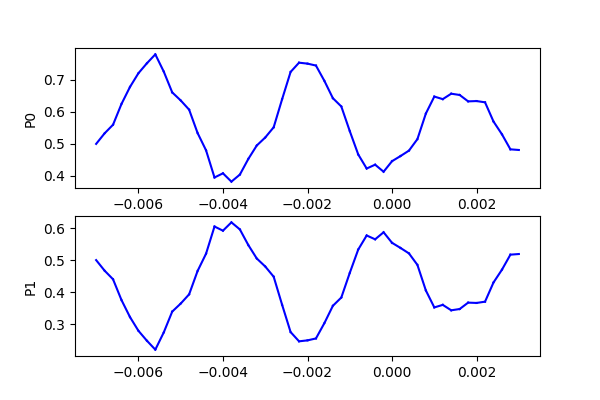

  0%|          | 0/51 [00:00<?, ?it/s]

2022-12-12 11:16:55 |  RESULT  | Experiment results as follow:
|     name     |   describe   |                  value                   | unit |      quality      | 
-----------------------------------------------------------------------------------------------------
|   points_0   |   points_0   | detune peaks: [-0.0056, -0.0022, 0.0014] | None | R²=0.9352(normal) | 
| fit_points_0 | fit_points_0 | detune peaks: [-0.0056, -0.002, 0.0016]  | None | R²=0.9352(normal) | 
2022-12-12 11:16:55 |   EXP    | theta_type: Xpi, N: 8
2022-12-12 11:17:02 |   EXP    | APE register success, id 63969d2ebdc7464e55fa4e68
2022-12-12 11:17:02 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q70\2022-12-12\11.14.41\APEComposite\11-14-41-RoughScan\APE\11-16-55-N=8\


<IPython.core.display.Javascript object>


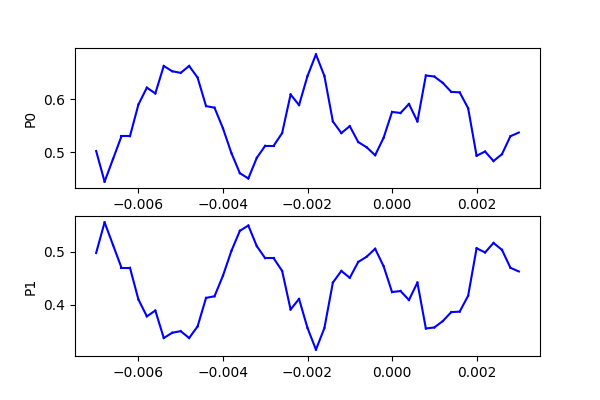

  0%|          | 0/51 [00:00<?, ?it/s]

2022-12-12 11:18:16 |  RESULT  | Experiment results as follow:
|     name     |   describe   |                       value                       | unit |       quality       | 
----------------------------------------------------------------------------------------------------------------
|   points_0   |   points_0   | detune peaks: [-0.0054, -0.0048, -0.0018, 0.0008] | None | R²=0.8324(abnormal) | 
| fit_points_0 | fit_points_0 |       detune peaks: [-0.005, -0.002, 0.001]       | None | R²=0.8324(abnormal) | 
2022-12-12 11:18:17 |   EXP    | theta_type: Xpi, N: 7
2022-12-12 11:18:21 |   EXP    | APE register success, id 63969d7dbdc7464e55fa4e94
2022-12-12 11:18:21 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q70\2022-12-12\11.14.41\APEComposite\11-18-17-FineScan\APE\11-18-17-N=7\


<IPython.core.display.Javascript object>


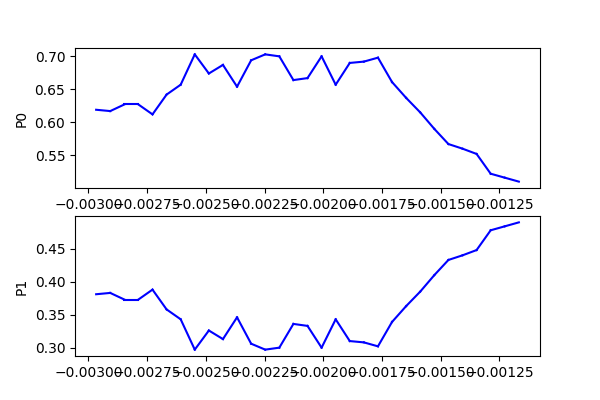

  0%|          | 0/31 [00:00<?, ?it/s]

2022-12-12 11:19:24 |  RESULT  | Experiment results as follow:
|     name     |   describe   |                value                 | unit |      quality      | 
-------------------------------------------------------------------------------------------------
|   points_0   |   points_0   | detune peaks: [-0.002547, -0.002247] | None | R²=0.9202(normal) | 
| fit_points_0 | fit_points_0 |      detune peaks: [-0.002247]       | None | R²=0.9202(normal) | 
2022-12-12 11:19:24 |   EXP    | theta_type: Xpi, N: 9
2022-12-12 11:19:29 |   EXP    | APE register success, id 63969dc1bdc7464e55fa4ec0
2022-12-12 11:19:29 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\DetuneCalibration\q70\2022-12-12\11.14.41\APEComposite\11-18-17-FineScan\APE\11-19-24-N=9\


<IPython.core.display.Javascript object>


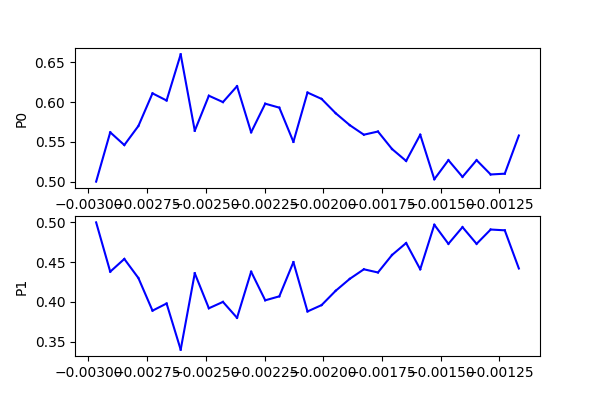

  0%|          | 0/31 [00:00<?, ?it/s]

2022-12-12 11:20:32 |  RESULT  | Experiment results as follow:
|     name     |   describe   |                      value                      | unit |    quality     | 
---------------------------------------------------------------------------------------------------------
|   points_0   |   points_0   | detune peaks: [-0.002607, -0.002367, -0.002067] | None | R²=0.0806(bad) | 
| fit_points_0 | fit_points_0 |                detune peaks: []                 | None | R²=0.0806(bad) | 


ValueError: not enough values to unpack (expected at least 2, got 1)

In [41]:
dec = DetuneCalibration.from_experiment_context(context)

dec.set_experiment_options(
    detune_list=qarange(-7e-3, 3e-3, 0.2e-3),
    rough_n_list=[6, 7, 8],
    fine_n_list=[7, 9],
    theta_type="Xpi",
    fine_precision=0.03e-3,
#     simulator_data_path='../scripts/simulator/data/DetuneCalibration/'
)

dec.set_analysis_options(diff_threshold=0.2)
dec.child_experiment.child_experiment.set_experiment_options(ac_prepare_time=1000,)

dec.run()

#### 查询实验结果

In [37]:
pd.DataFrame(dec.analysis.show_results())

,name,value,unit,extra,quality
0,detune,-0.002,GHz,{},evaluate good


#### 查询实验结果图

In [42]:
dec.analysis.drawer.figure

AttributeError: 'NoneType' object has no attribute 'drawer'

In [43]:
qubit.XYwave.detune_pi = -2
qubit.XYwave.detune_pi2 = -2
pyqlog.info(f'Update {qubit} detune_pi {qubit.XYwave.detune_pi}MHz!')
qubit.save_data()

2022-12-12 11:24:42 |   INFO   | Update Qubit(bit=70) detune_pi -2MHz!
2022-12-12 11:24:42 |  UPDATE  | Save q70 to data service success.


In [55]:
dec.analysis.quality

'evaluate good'

#### 更新比特参数信息

In [34]:
detune_pi = dec.analysis.results.detune.value * 1e3
if 'evaluate good' in dec.analysis.quality:
    qubit.XYwave.detune_pi = detune_pi
    qubit.XYwave.detune_pi2 = detune_pi
    pyqlog.info(f'Update {qubit} detune_pi {qubit.XYwave.detune_pi}MHz!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-07 18:18:27 |   INFO   | Experiment results bad, please check!


### AmpOptimize

幅值优化实验，改实验通过微调 X 门驱动幅值，精细校准 X 门幅值

2022-12-12 11:26:41 |   EXP    | theta_type: Xpi, N: 7
2022-12-12 11:26:46 |   EXP    | AmpOptimize register success, id 63969f76bdc7464e55fa4f28
2022-12-12 11:26:46 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\AmpOptimize\q70\2022-12-12\11.26.41\


<IPython.core.display.Javascript object>


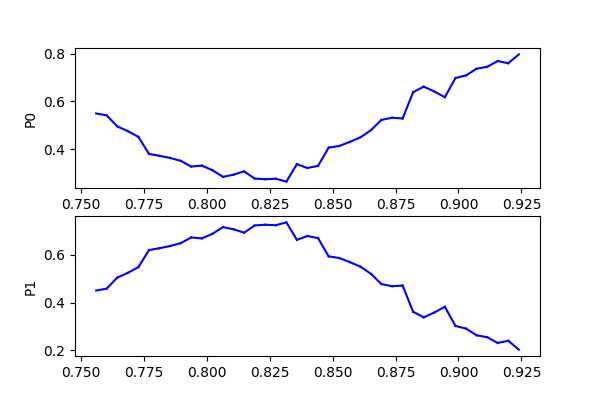

  0%|          | 0/41 [00:00<?, ?it/s]

2022-12-12 11:27:23 |  RESULT  | Experiment results as follow:
| name | describe | value  | unit |      quality       | 
--------------------------------------------------------
| Xpi  |  X-amp   | 0.8148 |  V   | R²=0.9849(perfect) | 


In [49]:
ao = AmpOptimize.from_experiment_context(context)
ao.set_experiment_options(
    theta_type="Xpi", N=7,
    points=41,
#     simulator_data_path='../scripts/simulator/data/AmpOptimize/'
)

ao.run()

#### 查询实验结果

In [159]:
pd.DataFrame(ao.analysis.show_results())

,name,value,unit,extra,quality
0,X-amp,0.82,V,{},R²=0.9697(normal)


#### 更新比特参数

In [50]:
ao_quality = ao.analysis.quality.descriptor
Xpi = ao.analysis.results.Xpi.value

if ao_quality == Quality.perfect:
    qubit.XYwave.Xpi = Xpi
    pyqlog.info(f'Update {qubit} Xpi {qubit.XYwave.Xpi}V!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-12-12 11:28:05 |   INFO   | Update Qubit(bit=70) Xpi 0.8148V!
2022-12-12 11:28:05 |  UPDATE  | Save q70 to data service success.


In [ ]:
# ao_quality = ao.analysis.quality.descriptor
# Xpi2 = ao.analysis.results.Xpi2.value

# if ao_quality == Quality.perfect:
#     qubit.XYwave.Xpi2 = Xpi2
#     pyqlog.info(f'Update {qubit} Xpi2 {qubit.XYwave.Xpi2}V!')
#     qubit.save_data()
# else:
#     pyqlog.info(f'Experiment results bad, please check!')

### T1

测量比特纵向退相干时间 `T1`

2022-12-07 21:57:21 |   EXP    | T1 register success, id 63909bc1a54d33e5c2c8a8b5
2022-12-07 21:57:21 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\T1\q71\2022-12-07\21.57.00\


<IPython.core.display.Javascript object>


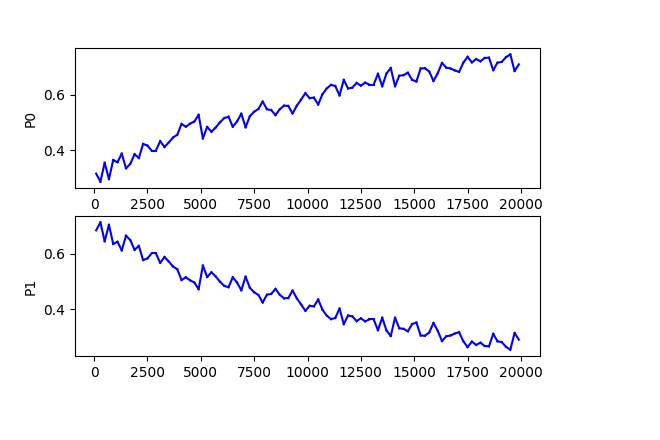

  0%|          | 0/100 [00:00<?, ?it/s]

2022-12-07 21:58:46 |  RESULT  | Experiment results as follow:
| name | describe |  value  | unit |      quality       | 
---------------------------------------------------------
| tau  |    T1    | 14.7295 |  us  | R²=0.9684(perfect) | 
| rate |   rate   |  0.74   | None | R²=0.9684(perfect) | 


In [102]:
t1_exp = T1.from_experiment_context(context)
t1_exp.set_experiment_options(
    ac_prepare_time=1000,
    delay_list=qarange(100, 20000, 200),
    z_amp = 0,
    schedule_index = [0,-1]
    
    
#     simulator_data_path='../scripts/simulator/data/T1/'
)

t1_exp.run()

#### 查看实验结果图

In [ ]:
t1_exp.analysis.drawer.figure

#### 更新比特参数

In [ ]:
t1_quality = t1_exp.analysis.quality.descriptor
t1 = t1_exp.analysis.results.tau.value * 1e3

if t1_quality == Quality.perfect:
    qubit.T1 = t1
    pyqlog.info(f'Update {qubit} T1 {qubit.T1}ns!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

### T2

测量比特横向退相干时间 `T2`

2022-12-07 22:04:34 |   EXP    | T2Ramsey run_once count: 0
2022-12-07 22:05:49 |   EXP    | T2Ramsey register success, id 63909dbca54d33e5c2c8aaa5
2022-12-07 22:05:49 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\T2Ramsey\q71\2022-12-07\22.04.34\
2022-12-07 22:05:49 |   EXP    | fringe: 646.667 MHZ, zamp: None v


<IPython.core.display.Javascript object>


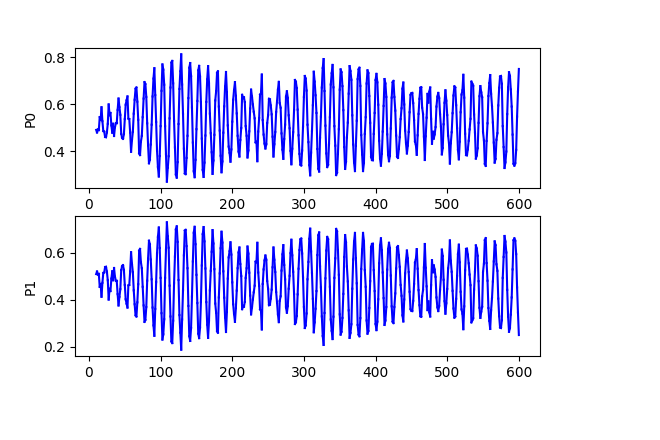

  0%|          | 0/473 [00:00<?, ?it/s]

2022-12-07 22:11:09 |  RESULT  | Experiment results as follow:
|  name   | describe |     value     | unit |    quality     | 
--------------------------------------------------------------
|   tau   |  T2star  | 5.35578608001 |  us  | R²=0.7115(bad) | 
|  freq   |   fosc   |   80.85373    | MHz  | R²=0.7115(bad) | 
| t2_rate | t2_rate  | 8.92631013335 | None | R²=0.7115(bad) | 


In [105]:
t2_exp = T2Ramsey.from_experiment_context(context)
t2_exp.set_experiment_options(
    ac_prepare_time=1000,
    delays=qarange(10, 600, 1.25),
    fringe=566.667 + 80,
    max_loops=1
#     simulator_data_path='../scripts/simulator/data/T2/'
)

t2_exp.run()

#### 查询实验结果

In [170]:
pd.DataFrame(t2_exp.analysis.show_results())

,name,value,unit,extra,quality
0,T2star,8.051146,us,{},R²=0.9599(normal)
1,fosc,1.015510,MHz,{},R²=0.9599(normal)
2,t2_rate,0.619319,None,{},R²=0.9599(normal)


#### 查询实验结果图

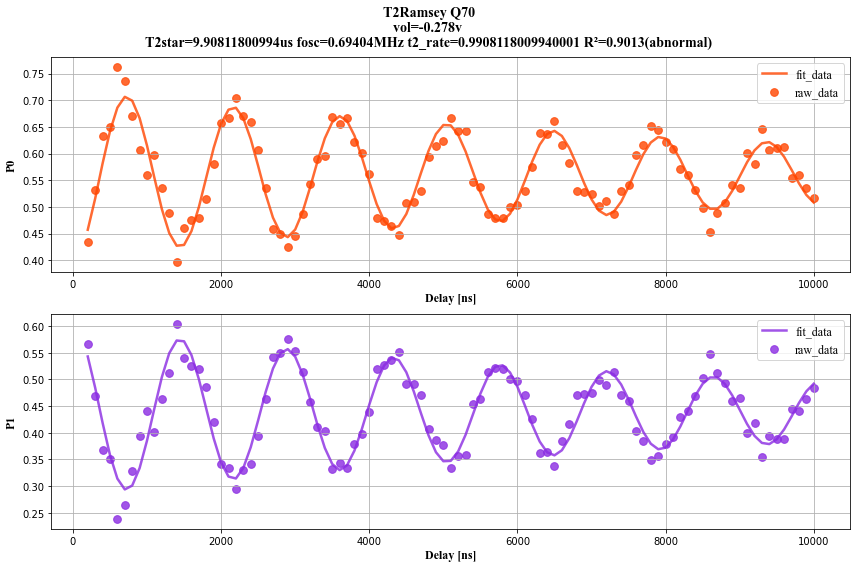

In [53]:
t2_exp.analysis.drawer.figure

#### 更新比特参数

In [173]:
t2 = t2_exp.analysis.results.tau.value * 1e3
qubit.T2 = t2
pyqlog.info(f'Update {qubit} T2 {qubit.T2}ns!')
qubit.save_data()

2022-11-21 21:34:22 |   INFO   | Update Qubit(bit=70) T2 8051.14619389ns!
2022-11-21 21:34:22 |  UPDATE  | Save q70 to data service success.


In [176]:
t2_quality = t2_exp.analysis.quality.descriptor
t2 = t2_exp.analysis.results.tau.value * 1e3

if t2_quality == Quality.normal:
    qubit.T2 = t2
    pyqlog.info(f'Update {qubit} T2 {qubit.T2}ns!')
    qubit.save_data()
else:
    pyqlog.info(f'Experiment results bad, please check!')

2022-11-21 21:35:30 |   INFO   | Update Qubit(bit=70) T2 8051.14619389ns!
2022-11-21 21:35:30 |  UPDATE  | Save q70 to data service success.


## swap

### 实验参数配置

In [20]:
qubit.ac_spectrum

Options(standard=[4795.9724735, -2017.53942185, 4.56593141, -0.00062481, 0.18062012])

In [23]:
freq2amp_formula(4098,*qubit.ac_spectrum.standard)

0.06914152257517951

In [10]:
def multiple_qubit_cali_context(
    qubit_name: str,
    parking_bits: list,
    parking_zamp: list,
    env_bit: list,
    use_dcm: bool = False,
    ac_switch: bool = True
):
    """ 应用场景：
        - 单比特表征所有流程
    """
    context = ExperimentContext(conf_file)
    context.configure_inst()

    context.configure_qubits([qubit_name]+parking_bits)
    
    
    new_env_bit = []
    for bit in env_bit:
        base_bit = context.get_base_qubit(bit)
        if base_bit.name == qubit_name:
            base_bit.ac = base_bit.dc_max
        elif base_bit.name in parking_bits:
            base_bit.ac = base_bit.dc_max + parking_zamp[parking_bits.index(base_bit.name)]
        elif isinstance(base_bit, Qubit):
            base_bit.ac = base_bit.dc_min
        else:
            base_bit.ac = base_bit.dc_max
        new_env_bit.append(base_bit)
    

    if ac_switch:
        context.maximize_compensate()
    else:
        context.minimize_compensate()
    context.configure_environment(new_env_bit)
    context.configure_crosstalk_dict()

    if use_dcm:
        context.configure_dcm(qubit_name)

    return context

In [11]:
context = multiple_qubit_cali_context(q_name, parking_bits, parking_zamp, ENV_BIT, use_dcm=False, ac_switch=True)
qubit = context.qubit

2022-12-04 20:41:25 |   INFO   | 
|=============================================================|
|                       Invoker Envrion                       |
|=============================================================|
|    invoker_addr    |       tcp://192.168.110.211:8088       |
|    point_label     |              freestyle_2q              |
|       sample       |220826-72bit-300pin-V8.2-Base-24#_monster|
|      env_name      |             D1_env(QT8013)             |
|      version       |                0.0.2.2                 |
|=============================================================|

2022-12-04 20:41:26 | WARNING  | Qubit(bit=70) is already exist in current environment.
2022-12-04 20:41:26 | WARNING  | Qubit(bit=71) is already exist in current environment.


#### 检索 DC 配置信息

In [13]:
pd.DataFrame(context.work_dc_table())

,qubit,z_dc_channel,value
0,Coupler(bit=7172),9,0.0v
1,Qubit(bit=71),21,-0.278v


In [12]:
pd.DataFrame(context.work_ac_table())

,qubit,z_flux_channel,value,m_pulse_model,m_pulse_params,compensate
0,Qubit(bit=64),14,0.091v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ64
1,Qubit(bit=65),9,0.082v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ65
2,Qubit(bit=69),22,0.118v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ69
3,Qubit(bit=70),21,-0.063v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ70
4,Qubit(bit=71),18,-0.07100000000000001v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ71
5,Qubit(bit=72),13,0.101v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionQ72
6,"Coupler(bit=6470, driveQ64, probeQ70)",23,-0.136v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC6470
7,"Coupler(bit=6571, driveQ65, probeQ71)",16,-0.119v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC6571
8,"Coupler(bit=6970, driveQ69, probeQ70)",24,0.092v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC6970
9,"Coupler(bit=7071, driveQ71, probeQ70)",19,0.107v,FlatTopGaussian,"Options(amp=0.0, sigma=1.25, buffer=5)",PulseCorrectionC7071


#### 检索线路补偿器信息

In [8]:
pd.DataFrame(context.compensates_table())

,name,x_delay,z_delay,z_compensate,distortion_width,distortion_data_len,distortion_ab,distortion_type
0,q64,0.0,0.000,0.0,0.0,0,[],width
1,q65,0.0,0.000,0.0,0.0,0,[],width
2,q69,0.0,0.000,0.0,0.0,0,[],width
3,q70,0.0,30.000,0.0,4405.0,157,[],width
4,q71,0.0,28.750,0.0,7605.0,12169,[],width
5,q72,0.0,0.000,0.0,0.0,0,[],width
6,c6470,0.0,0.000,0.0,0.0,0,[],width
7,c6571,0.0,0.000,0.0,0.0,0,[],width
8,c6970,0.0,0.000,0.0,0.0,0,[],width
9,c7071,0.0,35.625,0.0,9905.0,15849,[],width


In [13]:
context.configure_dcm('q70')

IQdiscriminator<center=[[-35.51525411 -23.09212618]
 [ 24.30696855  94.12006517]]>

### swap_once

2022-12-04 20:48:39 |   EXP    | scan_buffer: False
2022-12-04 20:48:39 |   EXP    | scan_high_bit: True
2022-12-04 20:48:41 |   EXP    | readout_type: high_bit
2022-12-04 20:48:50 |   EXP    | SwapOnce register success, id 638c973285f21dc0318cc894
2022-12-04 20:48:50 |   EXP    | Result path (local): E:\Data\D1\20221107\220826-72bit-300pin-V8.2-Base-24#_monster\SwapOnce\q70q71\2022-12-04\20.48.39\


<IPython.core.display.Javascript object>


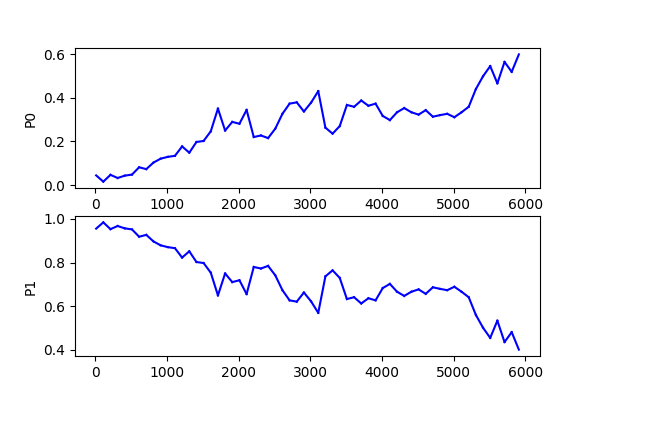

  0%|          | 0/60 [00:00<?, ?it/s]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [15]:
swap_once_exp = SwapOnce.from_experiment_context(context)

swap_once_exp.set_experiment_options(
        ac_prepare_time=1000,
        qh_name='q70',
        ql_name='q71',
        readout_type="high_bit",
        swap_state='10',
        const_z_amp=0.,
        z_amp=0.07,
        fixed_width=500,
        tc_list=qarange(10, 6000, 100),
        sigma=1.25,
        scan_buffer=False,
        scan_high_bit=True,
#         simulator_data_path='../data/Swap/',
        schedule_index=[0,-1],
        schedule_measure=True
    )


swap_once_exp.run()


In [10]:
{}.get(1)

In [17]:
context.discriminators

pyQCat.analysis.algorithms.iqprobability.IQdiscriminator